## Sources:

### Books:

<ul>
<li><a href="https://www.packtpub.com/big-data-and-business-intelligence/building-machine-learning-systems-python">Building Machine Learning Systems With Python</a>, by Willi Richert and Luis Pedro Coelho</li>
</ul>


### Sites:

<ul>
<li>http://opihi.cs.uvic.ca/sound/genres.tar.gz</li>
<li>http://stackoverflow.com/</li>
<li>http://sox.sourceforge.net/</li>
</ul>

In [13]:
from scipy.io import wavfile

Name of metal location:<br/>
metal.00001.wav - metal.00099.wav

In [70]:
musicMetalPath = "/Descargas/Music_Genres/genres/metal/"
GENRE_DIR = "/Descargas/Music_Genres/genres/"

Loading sample rate and samples from WAV file:

In [72]:
sample_rate, X = wavfile.read("./wavSamples/LYNCWH.CALLENDED.WAV")

Generating spectrogram:<br/>
<i>
The spectrogram shows the fequencis within a song, with their intensity (y=freqs intensity, x=time interv)
</i>

In [37]:
import scipy
from matplotlib.pyplot import specgram
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [22]:
print sample_rate, X.shape

48000 (35523L, 2L)


In [73]:
X

array([[  0,  -1],
       [ -1,   0],
       [  0,   0],
       ..., 
       [-14,  -2],
       [-15,  -7],
       [-13,  -3]], dtype=int16)

This file is sampled at a sample rate of 48,000Hz and contains two channels with 35,523 samples each one.<br/>
Since it is in stereo mode, let's convert it into mono.

In [23]:
ds = X.astype(float)

In [24]:
ds = ds.sum(axis=1) / 2

In [26]:
ds.shape

(35523L,)

Now we get the spectrogram

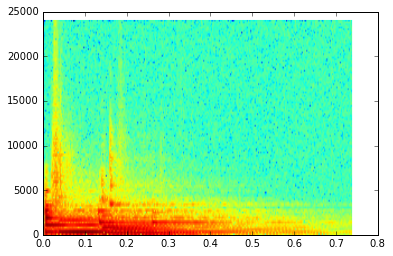

In [41]:
data, freqs, bins, im = specgram(ds, Fs=sample_rate)

### Extracting sine wave components

In [74]:
import os
import scipy
import wave

In [121]:
from sklearn.preprocessing import MaxAbsScaler

In [83]:
compname

'not compressed'

In [125]:
sample_rate, X = wavfile.read("/Descargas/Music_Genres/genres/disco/disco.00000.wav")
ds = X.astype(float)
#X = list(X)
max(X) # Sample seems to be 16-bit

23924

In [127]:
X.shape

(664180L,)

####  Frequency Spectrum - Fast Fourier Transform

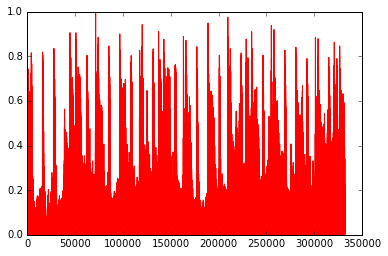

In [142]:
#a = X.T[0] # this is a two channel soundtrack, I get the first track
a = X
a = np.array(a).reshape((len(a), 1)) # Convert into 2D array needed for MaxAbsScaler.
maxabscaler = MaxAbsScaler()
b = maxabscaler.fit_transform(a) # Normalize -1,1
c = fft(b) # calculate fourier transform (complex numbers list)
d = len(c)/2  # you only need half of the fft list (real signal symmetry)
plt.plot(abs(c[:(d-1)]),'r') 
plt.show()

#### Spectogram

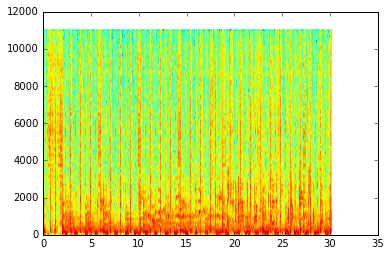

In [67]:
data, freqs, bins, im = specgram(ds, Fs=sample_rate)

The FFT data may be saved in a file to be reused later.<br/>
This is useful to compare different sample files FFT Frequency Spectrum.

In [46]:
def create_fft(fn):
    sample_rate, X = wavfile.read(fn)
    fft_features = abs(scipy.fft(X)[:1000])
    base_fn, ext = os.path.splitext(fn)
    data_fn = base_fn + ".fft"
    scipy.save(data_fn, fft_features)

And to read the <i>fft</i> files:

In [71]:
import glob
def read_fft(genre_list, base_dir=GENRE_DIR):
    X = []
    y = []
    for label, genre in enumerate(genre_list):
        genre_dir = os.path.join(base_dir, genre, "*.fft.npy")
        file_list = glob.glob(genre_dir)
    for fn in file_list:
        fft_features = scipy.load(fn)
        X.append(fft_features[:1000])
        y.append(label)
    return np.array(X), np.array(y)

### The classificator (chap 6)

The Bernoulli model of the Naïve Bayes classifier assigns a probability to class C knowing features F1 and F2. Word counts do not matter, only boolean features. P(C|F<sub>1</sub>,F<sub>2</sub>)<br/>
Later on we will implement the multinomial model of the classifier and use word counts instead to calculate probabilities.

### Fitting the problem with Bayesian Probability

Assuming that F<sub>1</sub> and F<sub>2</sub> are independent:


$$P\left (C|F_1,F_2 \right) = \frac {P\left(C\right) \cdot P\left(F_1|C\right) \cdot P\left(F_2|C\right)}{P\left(F_1,F_2 \right)}$$

For instance, to calculate the probability of a theme being either "blues" style or "classical", considering exclusively samples from those two styles:

$$P\left (C="blues"|F_1,F_2 \right) = \frac {P\left(C="blues"\right) \cdot P\left(F_1|C="blues"\right) \cdot P\left(F_2|C="blues"\right)}{P\left(F_1,F_2 \right)}$$

$$P\left (C="classical"|F_1,F_2 \right) = \frac {P\left(C="classical"\right) \cdot P\left(F_1|C="classical"\right) \cdot P\left(F_2|C="classical"\right)}{P\left(F_1,F_2 \right)}$$

We are interested on calculating the <i>argmax</i> of all <i>blues</i> and <i>classical</i> classes of <i>C</i> and keep only the class with the highest <i>P</i> value. We denote that class as <i>c<sub>best</sub></i>, more specifically:

$$
c_{best} = argmax_{c \in C}\; P\left(C=c\right)\cdot
P\left(F_1 |C = c\right) \cdot
P\left(F_2 |C = c\right)
$$

Decomposing the expression into its operands:

$$P\left (C="blues"\right) = \frac{\text{number of blues samples}}{\text{total number of samples}}$$

$$P\left (C="classical"\right) = \frac{\text{number of classical samples}}{\text{total number of samples}}$$

Now let's assume that we have two FFT frequency spectrum types, on is characteristic to <i>blues</i> and the other to <i>classical</i> samples. We call those features <i>F<sub>1</sub></i> and <i>F<sub>2</sub></i> respectively. We want to find out if we can classify random samples comparing their FFT frequency spectrum to the <i>blues</i> and <i>classical</i> samples frequency spectrums. In this case, <i>F<sub>1</sub></i> means that the current sample FFT frequency spectrum is more similar to <i>blues</i>. Conversely, <i>F<sub>2</sub></i> means that the current sample FFT frequency spectrum is more like <i>classical</i> charactersitic FFT frequency spectrum.

In that sense, the next expression would return the probability for any sample of <i>blues</i> class of having its FFT frequency spectrum closer the the <i>blues</i> characteristic spectrum:

$$
P\left(F_1=1 |C = "blues" \right) = \left(\frac{\text{number of blues samples having blues-similar FFT}}{\text{number of total blues samples}}\right)
$$

And, for instance, the next expression would be the number of classical samples having blues-similar FFT:

$$
P\left(F_1=0 |C = "classical" \right) = \left(\frac{\text{number of classical samples having NOT blues FFT}}{\text{number of total blues samples}}\right)
$$

Of course we are not expecting samples having exact matching neither <i>blues</i> nor <i>classical</i> FFT frequency spectrums, but having spectrums that are more similar to one of the two characteristic ones.

The other two probabilities can be deduced from the two previous examples and also we mention that they are the inverse of the another probability:

$$
P\left(F_2=1 |C = "blues" \right) = 1 - P\left(F_1=1 |C = "blues" \right)
$$

$$
P\left(F_2=1 |C = "classical" \right) =  1 - P\left(F_1=1 |C = "classical" \right)
$$

If we want to find the probabilty of two specific values for <i>F<sub>1</sub></i> and <i>F<sub>2</sub></i>, now we have the tools to do it. But first let's see what it means:

<ul>
<li>
<i>F<sub>1</sub></i> = 1, <i>F<sub>2</sub></i> = 0 --> FFT Frequency sample is more like <i>blues</i>
</li>
<li>
<i>F<sub>1</sub></i> = 0, <i>F<sub>2</sub></i> = 1 --> FFT Frequency sample is more like <i>classical</i>
</li>
<li>
<i>F<sub>1</sub></i> = 1, <i>F<sub>2</sub></i> = 1 --> FFT Frequency sample likelihood with <i>blues</i> is the same than for <i>classical</i>
</li>
</ul>

And the formula goes like that:

$$
P\left(F_1,F_2\right)=
P\left(F_1,F_2|C="blues"\right)\cdot
P\left(C="blues"\right)+
P\left(F_1,F_2|C="classical"\right)\cdot
P\left(C="classical"\right)
$$

The possible combinations are:
$$
P\left(F_1 = 1,F_2 = 0\right) \\
P\left(F_1 = 0,F_2 = 1\right) \\
P\left(F_1 = 1,F_2 = 1\right)
$$

Now we finally have all the elelemts required to replace the terms in the two main equations above:

$$P\left (C="blues"|F_1,F_2 \right) = \frac {P\left(C="blues"\right) \cdot P\left(F_1|C="blues"\right) \cdot P\left(F_2|C="blues"\right)}{P\left(F_1,F_2 \right)}$$

$$P\left (C="classical"|F_1,F_2 \right) = \frac {P\left(C="classical"\right) \cdot P\left(F_1|C="classical"\right) \cdot P\left(F_2|C="classical"\right)}{P\left(F_1,F_2 \right)}$$
